![](circuit.png)

In [1]:
import numpy as np
import control
from IPython.display import display, Markdown, Latex
import sys
sys.path.append('..')
from control_utils import * #biblioteca de funções que eu mesmo desenvolvi

# Formulação do problema

{'Mp': 9.477231373245008,
 'tp': 0.9815,
 'ts5': 1.307,
 'ts2': 1.4855,
 'tr': 0.4635,
 'td': 0.3395,
 'ess': -7.210767607235269e-06,
 'final_value_step_simulated': 1.0000072107676072,
 'final_value_step_theoretical': 0.7339449541284404}

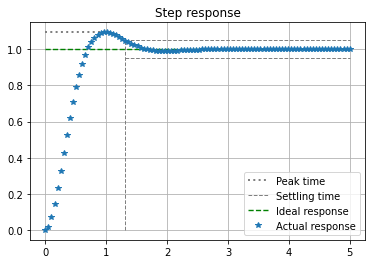

In [2]:
# Parâmetros dados
desired_zeta = 0.6
desired_wn = 4
T = 0.2
tfinal = 5

# Sistema resultante
desired_wd=desired_wn*np.sqrt(1-desired_zeta**2);
ws = 2*np.pi/T
desired_G = system_from_parameters(desired_zeta, desired_wn)
step_info(desired_G, tfinal)

In [3]:
# Sistema fornecido
Fs = control.tf(1, [1, 0])
Fz = control.c2d(Fs, T)

Gs = control.tf(1, [1, 2])
Gz = control.c2d(Gs, T)
Hs = control.tf(1, [1, 0])
GHs = Gs*Hs
GHz = control.c2d(GHs, T)

In [4]:
show_formatted(tf_zpk_format(GHz))

$$Y(z) = 0.01758*\frac{(s +0.8753)}{(s -1.0000)(s -0.6703)}$$

# A) Projeto

In [5]:
# Polo que satisfaz os parâmetros desejados
z1 = pole_for_parameters(desired_zeta, desired_wd, ws, T)
print('O polo desejado é z1 =', z1)

O polo desejado é z1 = (0.4963235336169597+0.3695346207773863j)


In [6]:
alpha=-0.6
display(Markdown(f'**alpha** = {alpha} (pré-determinado)'))

G2z = control.minreal(control.tf([1, alpha], [1],T)*GHz);
[[n2]],[[d2]] = control.tfdata(G2z);
fi2=np.angle(np.polyval(n2,z1)/np.polyval(d2,z1));
fi1=-np.pi-fi2;
beta=(np.imag(z1)-np.real(z1)*np.tan(-fi1))/np.tan(-fi1)  # Pela condição de ângulo
display(Markdown(f'**beta** = {beta}'))


Cz = control.tf([1, alpha], [1, beta], T)
ftma1=control.minreal(Cz*GHz)
[[n2]],[[d2]] = control.tfdata(ftma1);
k=1/np.real(np.abs((np.polyval(n2,z1)/np.polyval(d2,z1)))) # Pela condição de módulo
Cz = k*Cz
display(Markdown(f'**k** = {k}'))
display(Latex('$C(z)$ = ' + Cz._repr_latex_()))

display(Markdown('---------------'))
display(Markdown('## Sanity check'))
display(Markdown('O controlador deve fornecer %.2f graus'%((np.pi - np.angle(GHz(z1)))*180/np.pi)))
display(Markdown('O controlador calculado fornece %.2f graus'%(np.angle(Cz(z1))*180/np.pi)))
display(Markdown('$\\angle C(z)G(z)_{z=z1} = %.2f ^º$'%(np.angle((Cz*GHz)(z1))*180/np.pi)))
display(Markdown('$\\left|C(z)G(z)\\right|_{z=z1} = %.2f$'%(np.abs((Cz*GHz)(z1)))))

FTMFz = Fz*(Cz*Gz/(1+Cz*GHz))
FTMFz = control.minreal(FTMFz)

**alpha** = -0.6 (pré-determinado)

0 states have been removed from the model


**beta** = -0.08306705601996371

0 states have been removed from the model


**k** = 14.758185415337483

<IPython.core.display.Latex object>

---------------

## Sanity check

O controlador deve fornecer 63.87 graus

O controlador calculado fornece 63.87 graus

$\angle C(z)G(z)_{z=z1} = 180.00 ^º$

$\left|C(z)G(z)\right|_{z=z1} = 1.00$

3 states have been removed from the model


# B) Análise ao degrau

O bloco $F(z)$ é um integrador e, portanto, a sua resposta ao degrau deverá ser uma rampa.

Text(0.5, 1.0, 'Resposta ao degrau de $x(kT)$')

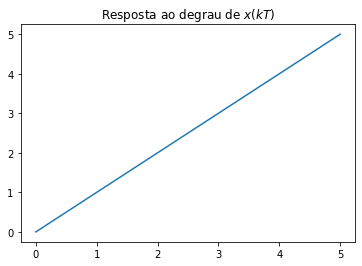

In [7]:
x,y = control.step_response(Fz, tfinal)
plt.plot(x,y)
plt.title('Resposta ao degrau de $x(kT)$')

# C) Erro em steady state

O erro foi determinado por:

$$
erro_{ss} = lim_{k\rightarrow \inf} r[k] - lim_{k\rightarrow \inf} FTMF(k)
$$

In [8]:
x, y = control.step_response(FTMFz, tfinal*100)
print("Erro de regime permanente final ao step:", 1 - y[-1])

Erro de regime permanente final ao step: -9.170442183403793e-14


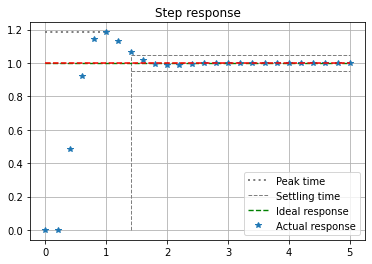

In [9]:
step_info(FTMFz, tfinal)
plt.hlines(1, 0, 5, linestyles='dashed', color='red')

# D) Implementação com equações recursivas

Para cada bloco discreto, utilizou-se a transformada Z inversa para obter a equação recursiva equivalente.

Tal manipulação é trivial e foi ocultada por breviedade.

In [10]:
display(Markdown('## Funções no domínio z'))
display(Latex('$F(z)$ = ' + Fz._repr_latex_()))
display(Markdown('-------------'))
display(Latex('$G(z)$ = ' + Gz._repr_latex_()))
display(Markdown('-------------'))
display(Latex('$GH(z)$ = ' + GHz._repr_latex_()))
display(Markdown('-------------'))
display(Latex('$C(z)$ = ' + Cz._repr_latex_()))

## Funções no domínio z

<IPython.core.display.Latex object>

-------------

<IPython.core.display.Latex object>

-------------

<IPython.core.display.Latex object>

-------------

<IPython.core.display.Latex object>

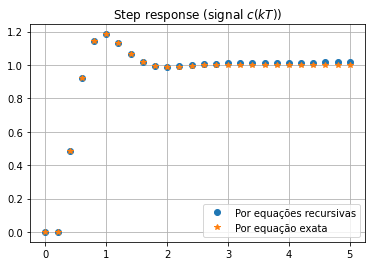

In [11]:
k_max = int(np.ceil(tfinal/T)) + 1
t = np.linspace(0, tfinal, k_max)
r = np.ones(k_max) #step

x = np.empty(k_max) # após f
e = np.empty(k_max) # após somador 
u = np.empty(k_max) # após C
c = np.empty(k_max) # após G
v = np.empty(k_max) # após GH
    
    
# Unroll first iterations to get initial conditions
n=0
x[n] = 0.2*0 + 1*0
c[n] = 0.1648*0 + 0.6703*0
v[n] = 0.01758*0 + 0.01539*0 + 1.67*0 - 0.6703*0
e[n] = x[n] - v[n] 
u[n] = 14.76*e[n] - 8.855*0 + 0.08307*0

n=1
x[n] = 0.2*r[n-1] + 1*x[n-1]
c[n] = 0.1648*u[n-1] + 0.6703*c[n-1]
v[n] = 0.01758*u[n-1] + 0.01539*0 + 1.67*v[n-1] - 0.6703*0
e[n] = x[n] - v[n] 
u[n] = 14.76*e[n] - 8.855*e[n-1] + 0.08307*u[n-1]


# Simulate system
for n in range(2, k_max):
    x[n] = 0.2*r[n-1] + 1*x[n-1]
    c[n] = 0.1648*u[n-1] + 0.6703*c[n-1]
    v[n] = 0.01758*u[n-1] + 0.01539*u[n-2] + 1.67*v[n-1] - 0.6703*v[n-2]
    e[n] = x[n] - v[n] 
    u[n] = 14.76*e[n] - 8.855*e[n-1] + 0.08307*u[n-1]
    
plt.plot(t,c, 'o', label='Por equações recursivas')
plt.title('Step response (signal $c(kT)$)')

x,y = control.step_response(FTMFz, tfinal)
plt.plot(x,y, '*', label='Por equação exata')

plt.grid()
plt.legend(loc='lower right')

Como podemos observar, a equação recursiva possui um erro cúmulativo

# E) Sinal de atuação

Utilizando o sistema simulado na questão anterior, observou-se o sinal de atuação, o qual não deve ultrapassar os limites físicos do hardware de implementação (que ainda não foi definido)



O valor máximo do sinal de atuação é 3.61
O valor mínimo do sinal de atuação é 0.00


Text(0.5, 1.0, 'Control signal $u(kT)$ for step response')

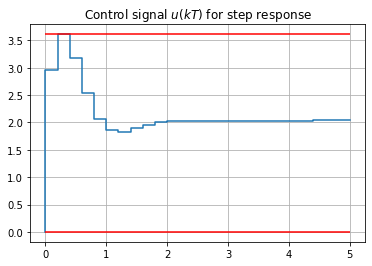

In [12]:
plt.step(t, u)
print('O valor máximo do sinal de atuação é %.2f'%(u.max()))
print('O valor mínimo do sinal de atuação é %.2f'%(u.min()))
plt.hlines(u.max(), t[0], t[-1], color='red')
plt.hlines(u.min(), t[0], t[-1], color='red')
plt.grid()
plt.title('Control signal $u(kT)$ for step response')

# Extras

(array([0.08306706]), array([0.6]))

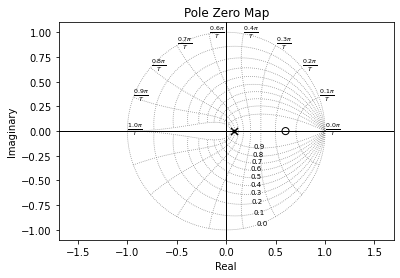

In [13]:
control.pzmap(Cz, grid=True)

(array([0.49632353+0.36953462j, 0.49632353-0.36953462j,
        0.50129097+0.j        ]),
 array([0.6]))

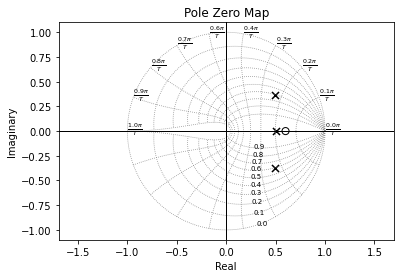

In [14]:
control.pzmap(FTMFz, grid=True)

/usr/local/lib/python3.8/dist-packages/control/timeresp.py:917: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


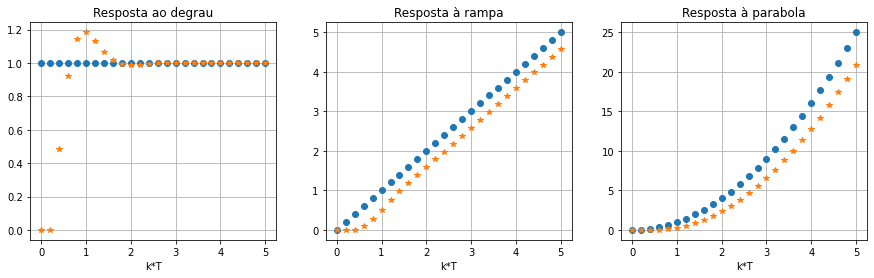

In [15]:
plot_responses(FTMFz, tfinal)